<a href="https://colab.research.google.com/github/claredavies/ImageIndexing/blob/master/Image_Descriptors_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

**Before you turn this problem in, please put your full names and DNIs (or NIEs) below, and execute the cell:**

In [1]:
NAME  = "CLARE DAVIES"
DNI   = "99999999R"

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. **Justify** all of your answers, **graphically** wherever possible. Remember that this notebook will be considered as a report to the work done during the assignment.

---

In [5]:
!git clone https://github.com/claredavies/ImageIndexing

Cloning into 'ImageIndexing'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 74 (delta 0), reused 3 (delta 0), pack-reused 71
Unpacking objects: 100% (74/74), 126.55 MiB | 14.50 MiB/s, done.


In [6]:
%cd ImageIndexing

/content/ImageIndexing


In [7]:
!git checkout master

Branch 'master' set up to track remote branch 'master' from 'origin'.
Switched to a new branch 'master'


In [9]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import skimage.feature as skfeat
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")
    
# import iric_utils.eval_holidays as ev
import iric_dev_kit.iric_utils.eval_holidays as ev

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
In this assignment, you will first learn the tools that we will used during the labs. Then, you will implement and evaluate some image description methods to develop a simple CBIR system.

### Tools
Several tools and libraries will be used throughout the semester, like:

*   [Python 3](https://docs.python.org/3/tutorial/)
*   [Numpy](https://docs.scipy.org/doc/numpy/user/quickstart.html)
*   [OpenCV](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)

It is important to be familiar with them. If that is not the case, please, follow the links above and have a look at the tutorials. There are some quickstart guides available on the course website on [Aula Digital](https://uibdigital.uib.es/).

### The INRIA Holidays dataset
During this course, we will mainly use the [INRIA Holidays](http://lear.inrialpes.fr/people/jegou/data.php) dataset. This dataset is a set of images which contains some personal holidays photos of the authors. The remaining ones were taken on purpose to test the robustness to various image transformations: rotations, viewpoint and illumination changes, blurring, etc. The dataset includes a very large variety of scene types (natural, man-made, water, fire effects, etc) and images are in high resolution. The dataset contains 500 image groups, each of which represents a distinct scene or object. 

For evaluation purposes, the first image of each group is used as the query image and the correct retrieval results are the other images of the group. For instance, the image named *100900.jpg* will be used as query while the corresponding relevant images for this query are images *100901.jpg* and *100902.jpg*, which belongs to the same group.

There are **1491 images in total**, from which **500** are **queries** (one for each group) and the remaining **991** are their corresponding **relevant images**.

### The INRIA Holidays Mini dataset
For development purposes, a small version of the INRIA Holidays dataset is provided for this course. In this reduced version of the dataset, there are **50 images in total**, from which **19** are **queries** and the remaining **31** are their corresponding **relevant images**.

> **Both datasets must be downloaded from [Aula Digital](https://uibdigital.uib.es/) and unzipped into the root directory of the development kit**.

### Performance evaluation
You are provided with a script to evaluate a CBIR system on these datasets. The performance is measured in terms of **mean average precision** (mAP), averaged over all queries (500 or 19, depending on the version of the dataset used). **This script is included in the development kit**.

This library provides two ways of calculating the mAP for a given set of results:
* Using the function `compute_mAP_from_file()`, which receives as parameters:
    * A resulting file following the original format provided by the authors (see [this link](http://lear.inrialpes.fr/people/jegou/data.php))
    * The ground truth filename
  
We provide a perfect results file for each version of the dataset computed from the ground truth as an example:

In [13]:
# Computing mAPs using ground truths
m_ap = ev.compute_mAP_from_file('holidays_mini/perfect_result_mini.dat', 'holidays_mini/holidays_images.dat')
print('mAP: %.5f' % m_ap)

mAP: 1.00000


* Using the function `compute_mAP()`, which receives:
    * The query results as a dictionary (see cell below)
    * The ground truth filename
  
You should use this version if you don't want to save your results into a temporary file. This dictionary should contain, for each query image, an ordered list of the retrieved images. For example:

In [14]:
# Reading the ground truth file to create a perfect results dictionary
res = {}
with open('holidays_mini/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
    
        # Checking if this is a query image
        if imno % 100 == 0:
            results = []
            res[imname] = results
        else:
            results.append(imname)
print(res)

{'100000.jpg': ['100001.jpg', '100002.jpg'], '100100.jpg': ['100101.jpg'], '100200.jpg': ['100201.jpg'], '100300.jpg': ['100301.jpg', '100302.jpg'], '100400.jpg': ['100401.jpg'], '100500.jpg': ['100501.jpg', '100502.jpg', '100503.jpg'], '100600.jpg': ['100601.jpg'], '100700.jpg': ['100701.jpg'], '100800.jpg': ['100801.jpg'], '100900.jpg': ['100901.jpg', '100902.jpg'], '101000.jpg': ['101001.jpg'], '101100.jpg': ['101101.jpg'], '101200.jpg': ['101201.jpg'], '101300.jpg': ['101301.jpg'], '101400.jpg': ['101401.jpg', '101402.jpg', '101403.jpg', '101404.jpg'], '101500.jpg': ['101501.jpg', '101502.jpg', '101503.jpg', '101504.jpg'], '101600.jpg': ['101601.jpg'], '101700.jpg': ['101701.jpg', '101702.jpg'], '101800.jpg': ['101801.jpg']}


Then you can use this dictionary and the corresponding function to validate a CBIR system:

In [15]:
m_ap = ev.compute_mAP(res, 'holidays_mini/holidays_images.dat')
print('mAP: %.5f' % m_ap)

mAP: 1.00000


### Loading images

For managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV2
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV2

In [17]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []

with open('holidays_mini/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread('holidays_mini/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_imgs))
print(len(train_imgs))

19
31


### Visualizing results
Additionally, you are also provided with a class called `ResultViz`, which includes two functions (`show_results` and `show_one_result`) to show graphically the retrieved results for a specific query. Here are some examples of how to use this class:

In [18]:
# Create the visualization object
rv = ev.ResultViz(query_names, query_imgs, train_names, train_imgs)

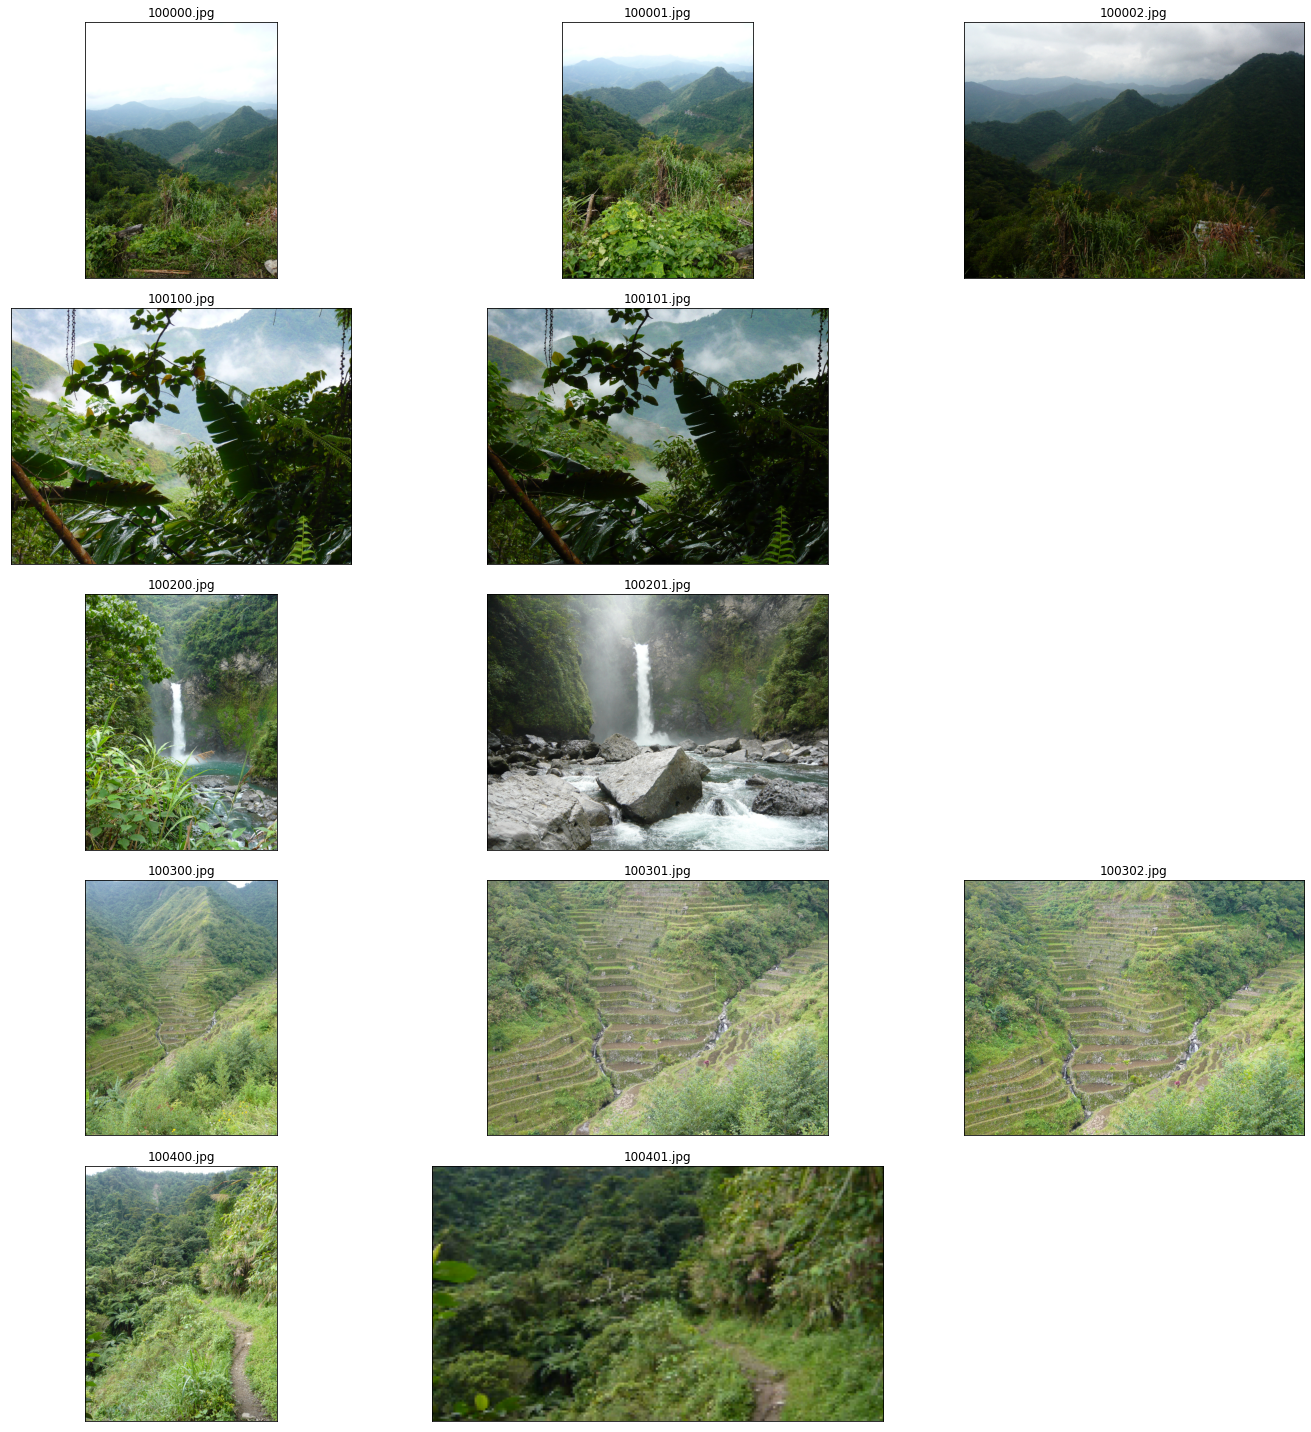

In [19]:
# Show the best 2 retrieved images for the first 5 queries
rv.show_results(res, nqueries = 5, ntrains = 2)

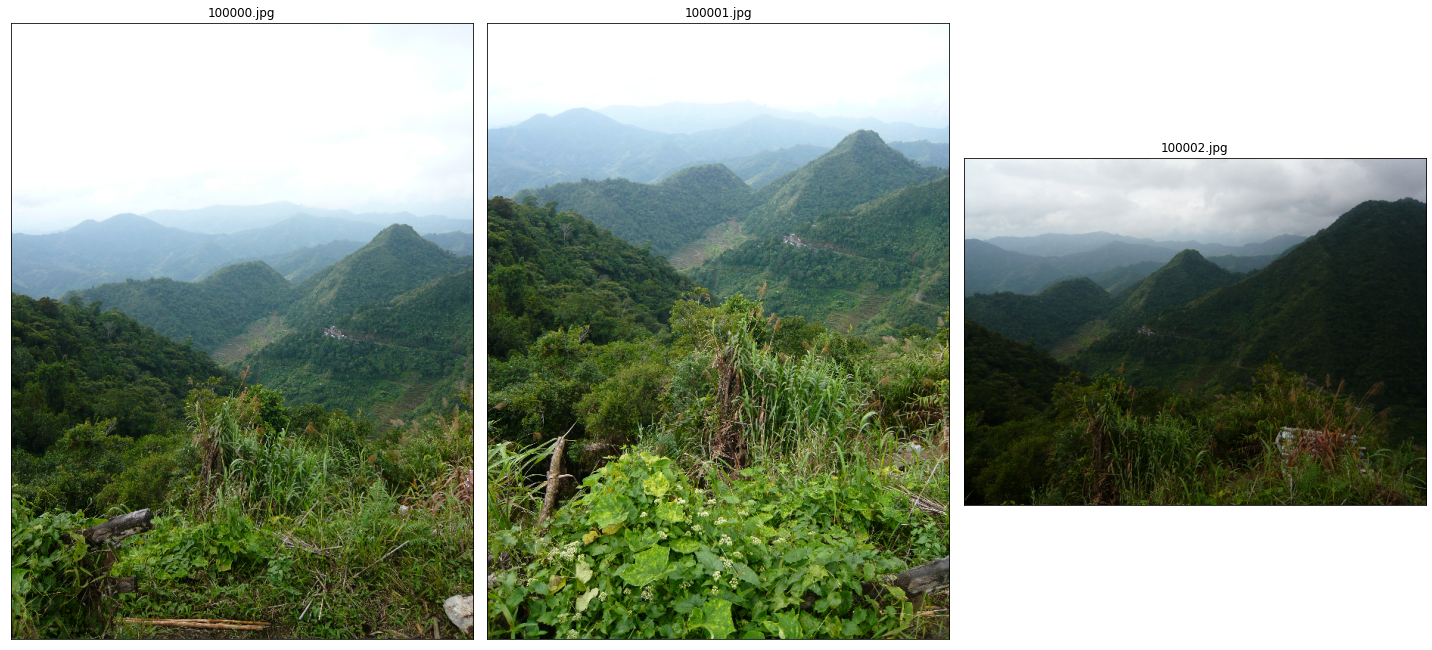

In [20]:
# Show the best 2 retrieved images for the query image '100000.jpg'
rv.show_one_result(res, '100000.jpg', ntrains = 2)

## Global descriptors
Once we have our development environment ready, it is time to start coding the assignment. At this section, we will use and evaluate some global descriptors to develop a simple image retrieval system.

### General framework
First, we will develop some utilities to simplify our work. Write a [Python class](https://docs.python.org/3/tutorial/classes.html) called `CBIR` that will encapsulate the main functionalities of a CBIR system, using the provided descriptions for each method. Assume that there exists a function that can compute a global descriptor of a given image called `desc_func`, which will be implemented later in the assignment:

In [21]:
class CBIR:
    """
    Class to encapsulate the basic functionalities of a CBIR system.
    """
    
    def __init__(self, desc_func, **kwargs):
        """
        Class constructor.
        
        - desc_func: The function to be used for describing the images
        - kwargs: A variable number of parameters required to call desc_func
        """
        self.desc_func = desc_func
        self.kwargs = kwargs
        
    def build_db(self, train_names, train_imgs):
        """
        Create the CBIR system database.
        
        - train_names: An ordered list of the names of the train images
        - train_imgs:  An ordered list of train images (Numpy arrays)
        
        This function should describe each image using desc_func and save the 
        resulting descriptors in a list of numpy arrays called train_descs.
        You should also save the names of each image in an attribute called
        train_names to associate each train image to its corresponding name.
        """
      
        self.train_names = []
        self.train_descs = []
        
        # YOUR CODE HERE
        raise NotImplementedError()
            
    def search_image(self, query_img):
        """
        Search an image in the system.
        
        - query_img: Query image (Numpy array)
        
        RETURNS:
        - An ordered list of tuples, each one with the format (L2 distance, train image name)
        
        This function should describe the query image using desc_func. Next, the resulting
        descriptor should be used to generate a list where each element is a tuple 
        (L2 distance, train image name), ordered according to the L2 distance between 
        the query descriptor and each corresponding train descriptor.
        """       
        
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def compute_mAP(self, query_names, query_imgs, gt_file):
        """
        Compute the mAP of a list of query images against the database.
        
        - query_names: An ordered list with the names of query images
        - query_imgs: An ordered list of query images (Numpy arrays)
        - gt_file = Ground truth file. Typically, 'holidays_images.dat'.
        
        RETURN: 
        - total_results: A dictionary containing, for each query image, an ordered list 
            of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        
        This function should use the other search_image to compute the mAP of a set 
        of queries against the database. You should return the final resulting 
        dictionary, formatted as explained previously, and the computed mAP.
        """
        
        total_results = {}
        m_ap = 0.0
        
        # YOUR CODE HERE
        raise NotImplementedError()
        
        return total_results, m_ap

### Color histograms
Let's start with histograms. Write a function for computing a descriptor based on 1D color histograms called `compute_1d_color_hist`. The final descriptor of the image will be the concatenation of the **normalized** color histograms of the three individual channels (B, G and R):

> **Useful functions**: [cv2.calcHist](https://docs.opencv.org/4.2.0/d6/dc7/group__imgproc__hist.html), [np.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html)

In [93]:
def compute_1d_color_hist(img, bins_per_hist = 32):
  histB = cv2.calcHist([img],[0],None,[bins_per_hist],[0,256]) 
  histG = cv2.calcHist([img],[1],None,[bins_per_hist],[0,256]) 
  histR = cv2.calcHist([img],[2],None,[bins_per_hist],[0,256]) 

  histBNorm, bins, p = plt.hist(histB, bins_per_hist, density=True)
  histGNorm, bins, p = plt.hist(histG, bins_per_hist, density=True)
  histRNorm, bins, p = plt.hist(histR, bins_per_hist, density=True)

  histConcat = np.concatenate([histBNorm, histGNorm, histRNorm]) 

  return histConcat

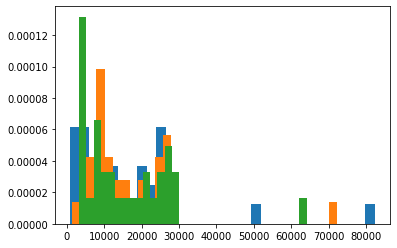

In [94]:
# Bins: 32
h = compute_1d_color_hist(train_imgs[0], 32);
assert h.shape == (96, )

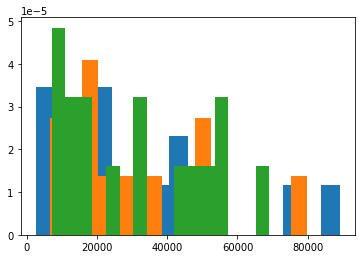

In [65]:
# Bins: 16
h = compute_1d_color_hist(train_imgs[0], 16);
assert h.shape == (48, )

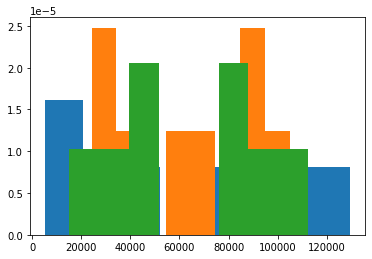

In [66]:
# Bins: 8
h = compute_1d_color_hist(train_imgs[0], 8);
assert h.shape == (24, )

**Q1**: Using this function and the `CBIR` class you wrote before, in the following cell compute the resulting **mAP** of the system **using 32 bins per histogram**:

In [ ]:
# Fill this variable with the resulting mAP
mAP_hist_1d = 0.0

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('mAP: %.5f' % mAP_hist_1d)

**Q2**: What is the effect of changing the number of bins per histogram?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

---
Now write a function called `compute_2d_color_hist` for computing a global descriptor of the image using 2D color histograms. The descriptor of the image will be the concatenation of the **normalized** histograms emerging from the three possible combinations of color channels (B/G, B/R and G/R):

In [119]:
def compute_2d_color_hist(img, bins_per_hist = 16):
    histB = cv2.calcHist([img],[0],None,[bins_per_hist],[0,256]) 
    histG = cv2.calcHist([img],[1],None,[bins_per_hist],[0,256]) 
    histR = cv2.calcHist([img],[2],None,[bins_per_hist],[0,256]) 

    histBNorm, bins, p = plt.hist(histB, bins_per_hist, density=True)
    histGNorm, bins, p = plt.hist(histG, bins_per_hist, density=True)
    histRNorm, bins, p = plt.hist(histR, bins_per_hist, density=True)

    histBGNorm = [i * j for j in histBNorm for i in histGNorm]
    histBRNorm = [i * j for j in histBNorm for i in histRNorm]
    histGRNorm = [i * j for j in histGNorm for i in histRNorm]

    histConcat = np.concatenate([histBGNorm, histBRNorm, histGRNorm]) 

    return histConcat
    # """
    # Compute a 2d color histogram of the image.
    
    # The final descriptor will be the concatenation of 3 normalized 2D histograms: B/G, B/R and G/R.
  
    # - img: Color image (Numpy array)
    # - bins_per_hist: Number of bins per histogram

    # RETURN:
    # - A numpy array of shape (bins_per_hist * bins_per_hist * 3,)
    # """

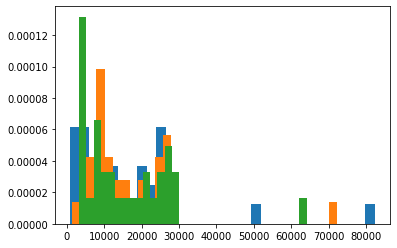

In [120]:
# Bins: 32
h = compute_2d_color_hist(train_imgs[0], 32);
assert h.shape == (3072, )

In [ ]:
# Bins: 16
h = compute_2d_color_hist(train_imgs[0], 16);
assert h.shape == (768, )

**Q3**: Using this function and the `CBIR` class you wrote before, in the following cell compute the resulting **mAP** of the system **using 32 bins per histogram**:

In [ ]:
# Fill this variable with the resulting mAP
mAP_hist_2d = 0.0

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('mAP: %.5f' % mAP_hist_2d)

**Q4**: What is the effect of changing the number of bins per histogram?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

### Local Binary Patterns (LBP)

Let's try LBP. Implement a function called `compute_lbp_descriptor` to calculate an image descriptor based on LBP's. The descriptor of the image should use the _rotation invariant_ and _uniform_ (_riu_) version of the algorithm. The final image descriptor will be the **normalized** histogram of the resulting LBP image:

> **Useful functions**: [skimage.feature.local_binary_pattern](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern)

In [ ]:
def compute_lbp_descriptor(img, p = 8, r = 1):
    """
    Compute a rotation invariant and uniform LBP histogram as image descriptor.
  
    - img: Input image (Numpy array)
    - p: Neighbors to check in radius r
    - r: Radius in pixels

    RETURN: 
    - A numpy array of shape (p + 2,)
    """    
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
h = compute_lbp_descriptor(train_imgs[0], 8, 1);
assert h.shape == (10, )

**Q5**: Using this function and the `CBIR` class you wrote before, in the following cell compute the resulting **mAP** of the system **checking 8 neighbors for each pixel at a distance of 1**:

In [ ]:
# Fill this variable with the resulting mAP
mAP_lbp = 0.0

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('mAP: %.5f' % mAP_lbp)

**Q6**: What is the effect of modifying the number of neighboring pixels $p$ and the radius $r$?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q7**: Study the effect of using a grid to describe the image.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Local descriptors
In this section we are going to retrieve images using some of the local descriptors we covered in class.

### Keypoint extraction / description

Let's start by writing a function called `extract_interest_points` to extract a set of keypoints from an image and their corresponding descriptors. The function will receive a parameter called `feat_type` to indicate what method should be used to detect and describe keypoints. This parameter can have one of the following string values:
- `SIFT`: SIFT detector / descriptor
- `FAST_BRIEF`: FAST detector / BRIEF descriptor
- `ORB`: ORB detector / ORB descriptor

> **Useful functions**: [cv2.SIFT_create()](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html#ad337517bfdc068ae0ba0924ff1661131),  [cv2.FastFeatureDetector_create](https://docs.opencv.org/4.5.4/df/d74/classcv_1_1FastFeatureDetector.html#ab986f2ff8f8778aab1707e2642bc7f8e), [cv2.xfeatures2d.BriefDescriptorExtractor_create](https://docs.opencv.org/4.5.4/d1/d93/classcv_1_1xfeatures2d_1_1BriefDescriptorExtractor.html#ae3bc52666010fb137ab6f0d32de51f60), [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

In [ ]:
def extract_interest_points(img, feat_type = 'SIFT', nfeats = 500, thresh = 50):
    """
    Compute keypoints and their corresponding descriptors from an image.
  
    - img: Input image (Numpy array)
    - feat_type: Detection / description method. See cell above
    - nfeats: Maximum number of features. It can be directly used to configure SIFT and ORB.
    - thresh: Detection threshold. Useful for FAST and ORB.
  
    RETURN:
    - kp: A tuple with the detected keypoints (cv2.KeyPoint)
    - des: A numpy array of shape (number_of_kps, descriptor_size) of type:
        - 'np.float32' for SIFT
        - 'np.uint8' for BRIEF and ORB
    """
    kp = []
    des = []
    
    # YOUR CODE HERE
    raise NotImplementedError()
  
    return kp,des

You can check the function showing the resulting keypoints (`cv2.drawKeypoints`):

In [ ]:
kps, des = extract_interest_points(query_imgs[1], 'SIFT', nfeats=2000, thresh=75)
sift_image = cv2.drawKeypoints(query_imgs[1], kps, None)

plt.imshow(sift_image)
plt.title('SIFT Keypoints')
plt.show()

### Matching images

Next, write a function called `find_matches` to match two set of descriptors. For simplicity, use a brute-force approach for binary descriptors and a FLANN-based approach for floating point descriptors:
> **Useful links**: [cv2.BFMatcher_create](https://docs.opencv.org/4.5.4/d3/da1/classcv_1_1BFMatcher.html#ac6418c6f87e0e12a88979ea57980c020), [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.4/dc/de2/classcv_1_1FlannBasedMatcher.html#a7b17083dda906384465a32952c1bbe3b), [Feature Matching](https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html)

In [ ]:
def find_matches(query_desc, train_desc, k = 2):
    """
    Match two sets of descriptors. For each query descriptor, this method searches
    the k closest descriptors in the train set.
  
    - query_desc: A numpy array of shape (number_of_kps_query, descriptor_size)
    - train_desc: A numpy array of shape (number_of_kps_train, descriptor_size)
    - k: Number of nearest neighbors descriptors to retrieve
  
    RETURN:
    - A tuple where each element is an item of matches, a tuple as well, containing:
        - As first item the best match (cv2.DMatch)
        - As second item, the second best match (cv2.DMatch)
        - And so on, until k
    """
    # YOUR CODE HERE
    raise NotImplementedError()

### Filtering matches

Write a function called `filter_matches` to filter the resulting matches according to the Nearest Neighbor Distance Ratio (NNDR) criterion:

In [ ]:
def filter_matches(matches, ratio = 0.75):
    """
    Given a tuple of matches, apply the NNDR test to filter them.
  
    - matches: A tuple of matches. See 'find_matches' for further info
    - ratio: Ratio to be applied between the best and the second best matches
        for each query
  
    RETURN:
    - A list of filtered matches, where each item is a cv2.DMatch object
      that fullfiled the ratio test condition.
    """
    # YOUR CODE HERE
    raise NotImplementedError()

You can check your implementation of these functions using `cv2.drawMatches`:

In [ ]:
# Extract keypoints from the query image
kps_q, des_q = extract_interest_points(query_imgs[1], 'SIFT', nfeats=3000, thresh=25)

# Extract keypoints from the train image
kps_t, des_t = extract_interest_points(train_imgs[2], 'SIFT', nfeats=3000, thresh=25)

raw_matches = find_matches(des_q, des_t)
print(len(raw_matches))

In [ ]:
matches = filter_matches(raw_matches, ratio = 0.6)
print(len(matches))
img_matches = cv2.drawMatches(query_imgs[0], kps_q, train_imgs[0], kps_t, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)
plt.title('Correct matches')
plt.show()

### Performance
We can now compare images using local feature descriptors. Given a query image, its closest one in the database will be the image with the **highest number matches after filtering**. Let's reimplement our function `compute_mAP` but using local feature descriptors:

In [ ]:
def compute_mAP(query_names, query_imgs, train_names, train_imgs, feat_type='SIFT', nfeats = 500, thresh = 40, ratio = 0.75):
    """
    Perform a search for a list of query images against the database using local 
    feature descriptors. Retrieved images should be sorted according to the 
    total number of matches, in reverse order.
    
    - query_names: An ordered list with the names of the query images
    - query_imgs: An ordered list of query images (Numpy arrays)
    - train_names: An ordered list with the names of the train images
    - train_imgs: An ordered list of train images (Numpy arrays)
    - feat_type: Detection / description method. See above
    - nfeats: Number of features. It can directly be configured for SIFT and ORB
    - thresh: Detection threshold. Useful for FAST and ORB
    - ratio: Ratio to be applied as NNDR
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, an sorted list of the database images
    - m_ap: Mean Average Precision averaged over all queries
    """
    
    total_results = {}
    m_ap = 0.0
    
    # YOUR CODE HERE
    raise NotImplementedError()
  
    return total_results, m_ap

In [ ]:
results, m_ap = compute_mAP(query_names, query_imgs, train_names, train_imgs)
print(m_ap)

**Q8**: For each method (SIFT, FAST/BRIEF and ORB), play with its corresponding parameters in order to achieve the best possible performance in terms of mAP.

In [ ]:
# Fill these variables with the best resulting mAPs
best_mAP_SIFT = 0.0
best_mAP_FASTBRIEF = 0.0
best_mAP_ORB = 0.0
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
print('Best mAP (SIFT): %.5f' % best_mAP_SIFT)
print('Best mAP (FAST/BRIEF): %.5f' % best_mAP_FASTBRIEF)
print('Best mAP (ORB): %.5f' % best_mAP_ORB)

**Q9**: Compare the three different methods in terms of accuracy. Which one is the most accurate method? Which one is the least?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q10**: Compare the three different methods in terms of detection/description speed. Which one is the fastest method? Which one is the slowest?

> **Hints**:
> - [Here](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) you can find a useful link about timing in Jupyter Notebooks
> - You can also consider using the `time` module
> - To provide a measure independent of the number of features found in the image, you can compute, for instance, features / ms

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [ ]:
zip_filename = DNI + '_A1.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A1/Image_Descriptors.ipynb'
zf.write('Image_Descriptors.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A1.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://uibdigital.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands